# Lab 4: Reconstruction from two views (knowing internal camera parameters)

In this lab you will learn how to triangulate the matching correspondences between two views of the same scene, by means of applying the Direct Linear Method (DLT). Then you will compute the camera matrices of these images given the Fundamental Matrix and the Intrinsic Matrix, and will evaluate your triangulation method on these camera matrices by estimating the reprojetion error in the triangulation. 

The last two tasks will involve the computation of depht maps by local methods (SSD, NCC), with their evaluation, and the implementation of bilateral weights on this mapping. 

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [1]:
!pip install opencv-contrib-python

     |████████████████████████████████| 56.3 MB 18.2 MB/s 
     |████████████████████████████████| 14.8 MB 46.9 MB/s 
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
from numpy import linalg as LA
import cv2
import math
import sys
import random
import matplotlib
from matplotlib import pyplot as plt
from operator import itemgetter

import utils
import aux_code as aux
import os

DATA_PATH="../../Data-Lab3"

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

### **1. Triangulation**

The first task is to implement the DLT method that will compute the 3D points corresponding to the matches of two images whose camera matrices are known. 

<span style='color:Green'> - Create the function triangulate(x1, x2, P1, P2, imsize) that performs a triangulation with the homogeneous algebraic method (DLT)  </span>

The entries are (x1, x2, P1, P2, imsize), where:
- x1, and x2 are two arrays of matching points in Euclidean coordinates from two different images.
- P1 and P2 are the two camera matrices of these images
- imsize is a two-dimensional vector with the image size

Test the triangulate function: use this code to validate that the function triangulate works properly


In [ ]:
# Write here the method for DLT triangulation

def triangulate(x1, x2, P1, P2, imsize):
    pass

In [ ]:
# Two camera matrices for testing purposes
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1
angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
t = np.array([[.3, .1, .2]])

P2 = np.concatenate((R, t.T), axis=1)
n = 8
rand = np.random.uniform(0,1,n)
rand = rand.reshape((1, n))
rand2 = np.random.uniform(0,1,2*n)
rand2 = rand2.reshape((2, n))
ones = np.ones((1,n))
X = np.concatenate((rand2, 3*rand, ones), axis=0)

x1_test = P1 @ X
x2_test = P2 @ X

# Estimate the 3D points (you need to create this function)
x_trian = np.zeros((4, n))
x_trian = triangulate(x1_test, x2_test, P1, P2, ((2,2)));

# Evaluation: compute the reprojection error
x_eucl = x_trian / x_trian[3][np.newaxis]
X_eucl = X / X[3][np.newaxis]

diff = X_eucl - x_eucl 

TypeError: 'NoneType' object is not subscriptable

### **2 Reconstruction from two views**

The goal of this section is to estimate the 3D reconstruction from two views in a practical situation where the image correspondences contain outliers. For that you will have first to compute the camera projection matrices

We will start by computing and visualizing the image matches.


In [ ]:
# Compute image correspondences #

# Read images
img1 = cv2.imread(os.path.join(DATA_PATH, '0000_s.png'),cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(DATA_PATH, 'Data/0001_s.png'),cv2.IMREAD_GRAYSCALE)
h, w = img1.shape

# Initiate ORB detector
orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

# Show "good" matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

NameError: name 'cv2' is not defined

5000 36


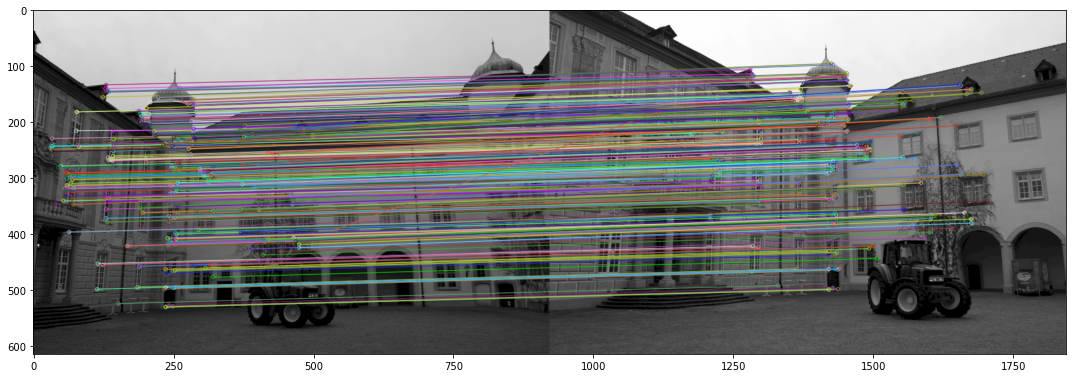

In [ ]:
# Robust estimation of the fundamental matrix #
points1 = []
points2 = []
for m in matches:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

F, indices_inlier_matches = aux.Ransac_fundamental_matrix(points1, points2, 1, 5000)
inlier_matches = itemgetter(*indices_inlier_matches)(matches)

img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

Now you should compute the candidate camera matrices.

In [ ]:
# Camera calibration matrix
K = np.array([[2362.12, 0, 1520.69], [0, 2366.12, 1006.81], [0, 0, 1]])
scale = 0.3;
H = np.array([[scale, 0, 0], [ 0, scale, 0], [0, 0, 1]])
K = H @ K;

<span style='color:Green'> - Compute the Essential matrix from the Fundamental matrix </span>

In [ ]:
E = essential_from_fundamental(...)


<span style='color:Green'> - Estimate the camera projection matrices </span>

In [ ]:
# camera projection matrix for the first camera
P1 = ...

# four possible matrices for the second camera
Pc2 = [4];
Pc2[0] = ...
Pc2[1] = ...
Pc2[2] = ...
Pc2[3] = ...

HINT: You may get improper rotations; in that case you need to change their sign.
  Let R be a rotation matrix, you may check:  
  
      if det(R) < 0  
          R = -R;  
      endif  

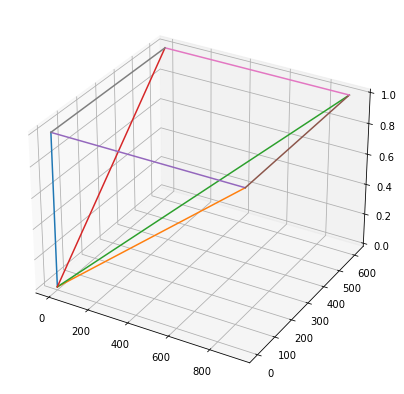

NameError: name 'plot_camera' is not defined

In [ ]:
# plot the first camera and the four possible solutions for the second figure:
utils.plot_camera(P1,w,h, 1);
utils.plot_camera(Pc2[0],w,h, 1);
utils.plot_camera(Pc2[1],w,h, 1);
utils.plot_camera(Pc2[2],w,h, 1);
utils.plot_camera(Pc2[3],w,h, 1);

<span style='color:Green'> -Choose a second camera candidate by triangulating a match </span>

In [ ]:
img1 = cv2.imread('Data/0000_s.png',cv2.IMREAD_UNCHANGED)

# Reconstruct structure
x1 = ...
x2 = ...
P2 = ...

# Triangulate all matches.
N = x1.shape[1]
X = np.zeros((4,N))
X = triangulate(x1, x2, P1, P2, [w, h])
X = X / X[3][np.newaxis]
X = np.transpose(X_eucl[:3])

# Render the 3D point cloud
x_img = np.transpose(x1[:2]).astype(int)
rgb_txt = (img1[x_img[:,0], x_img[:,1]])/255
utils.plot_points(X, rgb_txt)
#plot_camera(P1,w,h);
#plot_camera(P2,w,h);


(8, 3)

<span style='color:Green'> Compute the reprojection errors:  
    -plot the histogram of reprojection errors, and  
    -plot the mean reprojection error </span>

### **3. Depth map computation with local methods (SSD)**

Data images: 'scene1.row3.col3.ppm','scene1.row3.col4.ppm'  
Disparity ground truth: 'truedisp.row3.col3.pgm'

<span style='color:Green'> - Write a function called 'stereo_computation' that computes the disparity between a pair of rectified images using a local method based on a matching cost between two local windows.  </span>

The input parameters are 5:
- left image
- right image
- minimum disparity
- maximum disparity
- window size (e.g. a value of 3 indicates a 3x3 window)
- matching cost (the user may able to choose between SSD and NCC costs)

In this part we ask to implement only the SSD cost


<span style='color:Green'> - Evaluate the results changing the window size (e.g. 3x3, 9x9, 21x21,31x31) and the Mean Square Error (MSE). Comment the results.  </span>

 **Note 1**: Use grayscale images  
 
 **Note 2**: For this first set of images use 0 as minimum disparity and 16 as the the maximum one.

### **4. Depth map computation with local methods (NCC)**

<span style='color:Green'> - Complete the previous function by adding the implementation of the NCC cost. </span>

<span style='color:Green'>  Evaluate the results changing the window size (e.g. 3x3, 9x9, 21x21,31x31). Comment the results. </span>

### **5. Depth map computation with local methods**

Data images: '0001_rectified_s.png','0002_rectified_s.png'

<span style='color:Green'> - Test the functions implemented in the previous section with the facade images. Try different matching costs and window sizes and comment the results. </span>
    
Notice that in this new data the minimum and maximum disparities may change.

### **6. Bilateral weights**

<span style='color:Green'> - Modify the 'stereo_computation' so that you can use bilateral weights (or adaptive support weights) in the matching cost of two windows. </span>
    
Reference paper: Yoon and Kweon, "Adaptive Support-Weight Approach for Correspondence Search", IEEE PAMI 2006

<span style='color:Green'> -  Comment the results and compare them to the previous results (no weights).</span>

**Note**: Use grayscale images (the paper uses color images)

### OPTIONAL:  Stereo computation with Belief Propagation

Use the UGM library used in module 2 and implement a stereo computation method that minimizes a simple stereo energy with belief propagation. For example, use an L2 or L1 pixel-based data term (SSD or SAD) and the same regularization term you used in module 2. Or pick a stereo paper (based on belief propagation) from the literature and implement it. Pick a simple method or just simplify the method they propose.

### OPTIONAL:  Depth computation with Plane Sweeping

 Implement the plane sweeping method explained in class.

### OPTIONAL:  Depth map fusion 

In this task you are asked to implement the depth map fusion method presented in the following paper: B. Curless and M. Levoy. A Volumetric Method for Building Complex Models from Range Images. In Proc. SIGGRAPH, 1996.

1. Use the set of facade images 00xx_s.png to compute depth maps corresponding to different views (and optionally from different pairs of images for the same view).
2. Then convert each depth map to a signed distance function defined in a disretized volume (using voxels).
3. Average the different signed distance functions, the resulting signed distance is called D.
4. Set as occupied voxels (those representing the surface) those where D is very close to zero. The rest of voxels will be considered as empty.

For that you need to compute a depth map from a pair of views in general position (non rectified). Thus, you may either use the plane sweep algorithm (if you did it) or the local method for estimating depth (mandatory task) together with the following rectification method which has an online demo available: http://demo.ipol.im/demo/m_quasi_euclidean_epipolar_rectification/

### OPTIONAL:  New view synthesis

In this task you are asked to implement part of the new view synthesis method presented in the following paper: S. Seitz, and C. Dyer, View morphing, Proc. ACM SIGGRAPH 1996.

You will use a pair of rectified stereo images (no need for prewarping and postwarping stages) and their corresponding ground truth disparities (folder "new_view"). Remember to take into account occlusions as explained in the lab session. Once done you can apply the code to the another pair of rectified images provided in the material and use the estimated disparities with previous methods.
